# Leak Detection POC - Phase 3 - Model Build and Test Template

Simple notebook to test multiple classification models.  Using a NASA dataset from Kaggle for building the template, with local data and data on BQ.

Assuming this will be a multivariate, binary classification model per initial customer conversations.

Also, this is assuming the historical data is labeled.  If not, will likely need to take an anomaly detection approach, potentially SVM, kNN, neural networks, etc.

## Setup

GCP inputs:

In [1]:
# GCP details
REGION = 'us-central1'
PROJECT = 'mg-ce-demos'
DATANAME = 'leak'
NOTEBOOK = 'modelv1'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'
DEPLOY_IMAGE='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'

Packages:

In [27]:
# standard
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# GCP
from google.cloud import bigquery
from google.cloud import aiplatform

print('complete')

complete


Other parameters:

In [4]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"
local_data_link = 'data/neo.csv'

## Data Evaluation and Preperation

### Local

In [ ]:
df = pd.read_csv(local_data_link)

In [ ]:
df.info()
df.head()

In [ ]:
df.describe()

In [ ]:
df_numeric = df[['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]
sns.pairplot(df_numeric)

Notes:

Check for relationships between variables, such as linearity, to determine if any should be dropped

In [ ]:
from sklearn.linear_model import LinearRegression

# The max and min estimated diameter is linearly related. Maybe ellipsoid shape (approximately)?
x = np.array(df.est_diameter_max).reshape(-1,1)
y = np.array(df.est_diameter_min).reshape(-1,1)

model = LinearRegression().fit(x,y)
print(model.score(x,y),model.coef_,model.intercept_) 
# shows a perfect linear relation with ~0 intercept and slope of 0.45

In [ ]:
# drop unnecessary variables, such as max diameter due to linearity
X = df.drop(['id','name','est_diameter_max','orbiting_body','sentry_object','hazardous'],axis=1) 
y = df.hazardous.astype('int')
print(X.shape,y.shape)

In [ ]:
# Check for Duplicates 
print(f'Duplicates in Dataset: {df.duplicated().sum()}, ({np.round(100*df.duplicated().sum()/len(df),1)}%)')

In [ ]:
feature_names = [i for i in X]
feature_names

### GCP - BigQuery

In [5]:
# Define sql statement to submit to BigQuery
sql = """
SELECT 
    * 
FROM 
    `mg-ce-demos.leak_detection_poc.nasa_data`
"""

# Execute sql statment and export results to a dataframe
client = bigquery.Client(project=PROJECT)
df = client.query(sql).to_dataframe()

df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2005836,5836 (1993 MF),2.658000,5.943469,59702.805473,6.822094e+07,Earth,False,15.0,False
1,2068063,68063 (2000 YJ66),2.111324,4.721065,11482.256012,4.268007e+07,Earth,False,15.5,False
2,2052768,52768 (1998 OR2),1.677085,3.750075,42805.954217,2.684585e+07,Earth,False,16.0,True
3,2052768,52768 (1998 OR2),1.677085,3.750075,31325.704839,6.290365e+06,Earth,False,16.0,True
4,2138925,138925 (2001 AU43),1.677085,3.750075,127110.011670,5.552431e+07,Earth,False,16.0,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [7]:
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


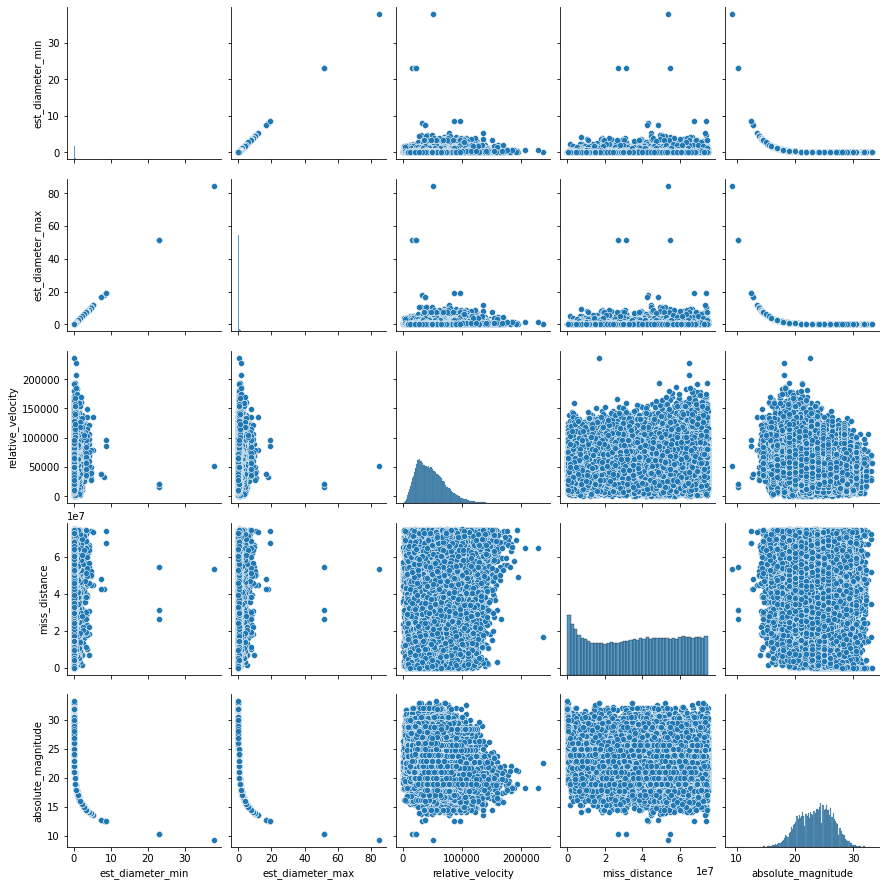

In [8]:
df_numeric = df[['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]
sns.pairplot(df_numeric)

In [9]:
# drop unnecessary variables, such as max diameter due to linearity
X = df.drop(['id','name','est_diameter_max','orbiting_body','sentry_object','hazardous'],axis=1) 
y = df.hazardous.astype('int')
print(X.shape,y.shape)

(90836, 4) (90836,)


In [10]:
# Check for Duplicates 
print(f'Duplicates in Dataset: {df.duplicated().sum()}, ({np.round(100*df.duplicated().sum()/len(df),1)}%)')

Duplicates in Dataset: 0, (0.0%)


In [11]:
feature_names = [i for i in X]
feature_names

['est_diameter_min',
 'relative_velocity',
 'miss_distance',
 'absolute_magnitude']

## Model Build and Test

In [12]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 123,stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72668, 4) (18168, 4) (72668,) (18168,)


In [13]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

### Decision Tree

In [14]:
start_time = time.time()

DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)

DTC_elapsed_time = round(time.time() - start_time, 4)
print(f"Cell time: {DTC_elapsed_time}s")

Cell time: 0.1879s


In [15]:
DTC_pred = DTC.predict(X_test)
acc_DTC = round(accuracy_score(DTC_pred, y_test) * 100, 2)
print(acc_DTC)

88.99


### Random Forest

In [16]:
start_time = time.time()

RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RF_elapsed_time = round(time.time() - start_time, 4)
print(f"Cell time: {RF_elapsed_time}s")

Cell time: 6.2932s


In [17]:
RF_pred = RF.predict(X_test)
acc_RF = round(accuracy_score(RF_pred, y_test) * 100, 2)
print(acc_RF)

91.58


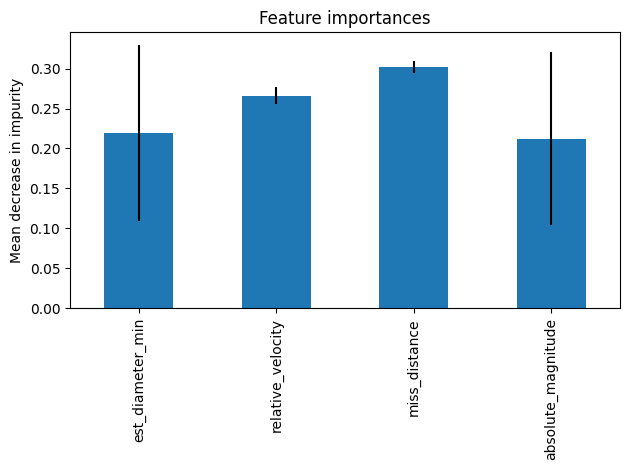

In [18]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### XGBoost

In [19]:
start_time = time.time()

XGBC = XGBClassifier()
XGBC.fit(X_train, y_train)

XGBC_elapsed_time = round(time.time() - start_time, 4)
print(f"Cell time: {XGBC_elapsed_time}s")

Cell time: 2.0657s


In [20]:
XGBC_pred = XGBC.predict(X_test)
acc_XGBC = round(accuracy_score(XGBC_pred, y_test) * 100, 2)
print(acc_XGBC)

91.84


### Gaussian Naive Bayes

In [21]:
start_time = time.time()

GNB = GaussianNB()
GNB.fit(X_train, y_train)

GNB_elapsed_time = round(time.time() - start_time, 4)
print(f"Cell time: {GNB_elapsed_time}s")

Cell time: 0.0154s


In [22]:
GNB_pred = GNB.predict(X_test)
acc_GNB = round(accuracy_score(GNB_pred, y_test) * 100, 2)
print(acc_GNB)

89.78


### Standard model comparison

In [23]:
# Display standard models

models = pd.DataFrame({
    'Model': ['DecisionTreeClassifier', 'Random Forest', 'XG Boost', 'Gaussian Naive Bayes'],
    'Score': [acc_DTC, acc_RF, acc_XGBC, acc_GNB],
    'Training Time (s)': [DTC_elapsed_time, RF_elapsed_time, XGBC_elapsed_time, GNB_elapsed_time]})
models.sort_values(by='Score', ascending=False)

,Model,Score,Training Time (s)
2,XG Boost,91.84,2.0657
1,Random Forest,91.58,6.2932
3,Gaussian Naive Bayes,89.78,0.0154
0,DecisionTreeClassifier,88.99,0.1879


### Neural network

In [24]:
NN = Sequential()
NN.add(Dense(12, input_dim=4, activation='relu'))
NN.add(Dense(8, activation='relu'))
NN.add(Dense(1, activation='sigmoid'))
NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
NN.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                60        
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


2022-06-23 11:33:18.986945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


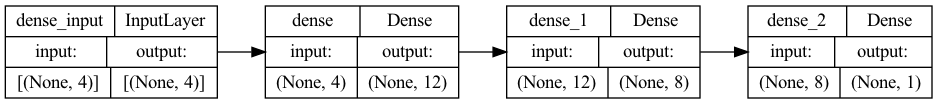

In [25]:
tf.keras.utils.plot_model(NN, show_shapes=True, rankdir='LR')


In [30]:
start_time = time.time()

# setup tensorboard logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = os.path.join(DIR, "logs", datetime.now().strftime("%Y%m%d-%H%M%S")), histogram_freq=1)
history = NN.fit(X_train, y_train, epochs = 10, callbacks = [tensorboard_callback], validation_split = 0.1, verbose = 1,shuffle = True)

# Fit Model
#history = NN.fit(X_train, y_train, batch_size = 18, epochs = 10, validation_split=0.1,verbose = 1,shuffle=True)

NN_elapsed_time = round(time.time() - start_time, 4)
print(f"Cell time: {NN_elapsed_time}s")

Epoch 1/10
2044/2044 [==============================] - 2s 867us/step - loss: 14408.4971 - accuracy: 0.7638 - val_loss: 6957.8120 - val_accuracy: 0.8807
Epoch 2/10
2044/2044 [==============================] - 2s 792us/step - loss: 11212.5742 - accuracy: 0.7965 - val_loss: 6991.7583 - val_accuracy: 0.8896
Epoch 3/10
2044/2044 [==============================] - 2s 782us/step - loss: 9754.8125 - accuracy: 0.7991 - val_loss: 21023.9668 - val_accuracy: 0.9028
Epoch 4/10
2044/2044 [==============================] - 2s 828us/step - loss: 10143.5986 - accuracy: 0.8031 - val_loss: 482.3675 - val_accuracy: 0.6901
Epoch 5/10
2044/2044 [==============================] - 2s 777us/step - loss: 6831.6426 - accuracy: 0.8092 - val_loss: 568.1834 - val_accuracy: 0.7449
Epoch 6/10
2044/2044 [==============================] - 2s 1ms/step - loss: 7519.1548 - accuracy: 0.8055 - val_loss: 5042.4253 - val_accuracy: 0.9044
Epoch 7/10
2044/2044 [==============================] - 3s 1ms/step - loss: 6867.9512 - 

In [31]:
_, acc_NN = NN.evaluate(X_test, y_test)
acc_NN = acc_NN*100
print('Accuracy: %.2f' % (acc_NN))

568/568 [==============================] - 0s 631us/step - loss: 4317.2812 - accuracy: 0.9027
Accuracy: 90.27


In [32]:
%load_ext tensorboard


In [33]:
%tensorboard --logdir $DIR/logs


In [34]:
# Display all models

models = pd.DataFrame({
    'Model': ['DecisionTreeClassifier', 'Random Forest', 'XG Boost', 'Gaussian Naive Bayes', 'Simple Neural Network'],
    'Score': [acc_DTC, acc_RF, acc_XGBC, acc_GNB, acc_NN],
    'Training Time (s)': [DTC_elapsed_time, RF_elapsed_time, XGBC_elapsed_time, GNB_elapsed_time, NN_elapsed_time]})
models.sort_values(by='Score', ascending=False)

,Model,Score,Training Time (s)
2,XG Boost,91.840000,2.0657
1,Random Forest,91.580000,6.2932
4,Simple Neural Network,90.268606,20.7257
3,Gaussian Naive Bayes,89.780000,0.0154
0,DecisionTreeClassifier,88.990000,0.1879


Notes:

Priority accuracy (or other metrics as needed), but training time is important.  Could be improved using Vertex Training, GPUs, etc.

## Model Serving

### Save

In [35]:
NN.save(URI)

INFO:tensorflow:Assets written to: gs://mg-ce-demos/leak/models/modelv1/assets


### Upload

In [36]:
model = aiplatform.Model.upload(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    serving_container_image_uri = DEPLOY_IMAGE,
    artifact_uri = URI,
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating Model
Create Model backing LRO: projects/633472233130/locations/us-central1/models/7160736601658621952/operations/9184033228799868928
Model created. Resource name: projects/633472233130/locations/us-central1/models/7160736601658621952
To use this Model in another session:
model = aiplatform.Model('projects/633472233130/locations/us-central1/models/7160736601658621952')


In [37]:
model.display_name


'modelv1_leak_20220623112444'

### Create an endpoint

In [38]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating Endpoint
Create Endpoint backing LRO: projects/633472233130/locations/us-central1/endpoints/2569400344438112256/operations/753294726362300416
Endpoint created. Resource name: projects/633472233130/locations/us-central1/endpoints/2569400344438112256
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/633472233130/locations/us-central1/endpoints/2569400344438112256')


In [39]:
endpoint.display_name


'modelv1_leak_20220623112444'

### Deploy model to endpoint

In [40]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/633472233130/locations/us-central1/models/7160736601658621952 to Endpoint : projects/633472233130/locations/us-central1/endpoints/2569400344438112256
Deploy Endpoint model backing LRO: projects/633472233130/locations/us-central1/endpoints/2569400344438112256/operations/5124038164725366784
Endpoint model deployed. Resource name: projects/633472233130/locations/us-central1/endpoints/2569400344438112256


### Predict against deployed model

In [80]:
pred_df = client.query(query = """SELECT * FROM `mg-ce-demos.leak_detection_poc.nasa_data` LIMIT 10""").to_dataframe()
pred_df = pred_df.drop(['id','name','est_diameter_max','orbiting_body','sentry_object','hazardous'],axis=1) 
pred_df.head()

,est_diameter_min,relative_velocity,miss_distance,absolute_magnitude
0,2.658000,59702.805473,6.822094e+07,15.0
1,2.111324,11482.256012,4.268007e+07,15.5
2,1.677085,42805.954217,2.684585e+07,16.0
3,1.677085,31325.704839,6.290365e+06,16.0
4,1.677085,127110.011670,5.552431e+07,16.0


In [116]:
instances = [[i for i in pred_df.iloc[0]]]
instances

[[2.658, 59702.8054730947, 68220936.06155133, 15.0]]

In [117]:
prediction = endpoint.predict(instances = instances)
prediction

Prediction(predictions=[[0.0]], deployed_model_id='3644120184031019008', explanations=None)